<a href="https://colab.research.google.com/github/skywalker0803r/base_ball_detect_lab/blob/main/%E7%90%83%E7%A8%AE%E8%B7%9F%E5%A5%BD%E5%A3%9E%E7%90%83%E9%A0%90%E6%B8%AC%E6%A8%A1%E5%9E%8B_Shohei_Ohtani_%E9%9A%A8%E6%A9%9F%E6%A3%AE%E6%9E%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
'''
# 範例用法
player_name_list = [
    'Shohei_Ohtani_SL','Shohei_Ohtani_FS','Shohei_Ohtani_FF',
    'Gerrit_Cole_CH','Gerrit_Cole_FF','Gerrit_Cole_SL',
    'Yu_Darvish_FF','Yu_Darvish_FS','Yu_Darvish_SL',
]

for player_name in tqdm(player_name_list):
  output_dir = f'/content/drive/MyDrive/Baseball Movies/{player_name}_videos_4S/baseball_trajectory_bbox_with_pitch_type_description'

# 根據player_name去取得資料夾路徑 然後資料夾底下所有pkl讀進來
# 任一筆pkl內都是這樣的數據
{'trajectory': [(0, None, None), (1, None, None), (2, None, None), (3, None, None),...(207, np.float32(734.81177), np.float32(349.0252), np.float32(754.8683), np.float32(371.2365)],
 'pitch_type': 'ST', 'description': 'swinging_strike'}
其中'trajectory'是一個list每一個元素都是一個tuple tuple中第一個位置代表影片偵數 若該偵沒有畫面 後面就是兩個None
若該偵有畫面偵數後面會有四個np.float32數值代表x1, y1, x2, y2 然後每一個pkl的偵數都不一定 所以trajectory的長度也不一定
最後會有pitch_type和description 這兩個是類別欄位 有多種類別
我希望你做的是從player_name_list撈player_name找到對應資料夾 然後將該檔案內的pkl讀進來
每一個pkl檔都是機器學習用的Xy pair 其中trajectory是X pitch_type是y description也是y
我要做的是用隨機森林去學習trajectory和pitch_type和description之間的映射
由於trajectory長度不一樣該padding就padding吧
最後你要給我的應該是整理好的X,y 只需要簡單做訓練測試切分就可以丟到隨機森林模型訓練
你還要給我在訓練集上跟測試集上的混淆矩陣分類報告和圖pitch_type(y1) description(y2)都要
還要給我一個前處理跟推論pipeline未來我只需要將trajectory丟入就能知道pitch_type和description(方便我部屬推論模型使用)
'''

"\n# 範例用法\nplayer_name_list = [\n    'Shohei_Ohtani_SL','Shohei_Ohtani_FS','Shohei_Ohtani_FF',\n    'Gerrit_Cole_CH','Gerrit_Cole_FF','Gerrit_Cole_SL',\n    'Yu_Darvish_FF','Yu_Darvish_FS','Yu_Darvish_SL',\n]\n\nfor player_name in tqdm(player_name_list):\n  output_dir = f'/content/drive/MyDrive/Baseball Movies/{player_name}_videos_4S/baseball_trajectory_bbox_with_pitch_type_description'\n\n# 根據player_name去取得資料夾路徑 然後資料夾底下所有pkl讀進來\n# 任一筆pkl內都是這樣的數據\n{'trajectory': [(0, None, None), (1, None, None), (2, None, None), (3, None, None),...(207, np.float32(734.81177), np.float32(349.0252), np.float32(754.8683), np.float32(371.2365)],\n 'pitch_type': 'ST', 'description': 'swinging_strike'}\n其中'trajectory'是一個list每一個元素都是一個tuple tuple中第一個位置代表影片偵數 若該偵沒有畫面 後面就是兩個None\n若該偵有畫面偵數後面會有四個np.float32數值代表x1, y1, x2, y2 然後每一個pkl的偵數都不一定 所以trajectory的長度也不一定\n最後會有pitch_type和description 這兩個是類別欄位 有多種類別\n我希望你做的是從player_name_list撈player_name找到對應資料夾 然後將該檔案內的pkl讀進來\n每一個pkl檔都是機器學習用的Xy pair 其中trajectory是X pitch_type是y d

100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


== Pitch Type - Partial Test Set ==
              precision    recall  f1-score   support

          FF       0.63      0.46      0.53        26
          FS       0.71      0.79      0.75        28
          ST       0.57      0.65      0.61        31

    accuracy                           0.64        85
   macro avg       0.64      0.63      0.63        85
weighted avg       0.64      0.64      0.63        85



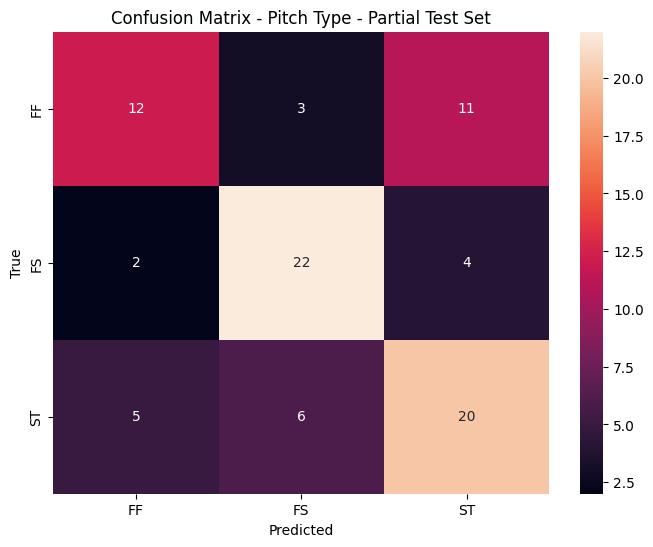

== Description - Partial Test Set ==
              precision    recall  f1-score   support

         bad       0.71      0.80      0.75        45
        good       0.74      0.62      0.68        40

    accuracy                           0.72        85
   macro avg       0.72      0.71      0.71        85
weighted avg       0.72      0.72      0.72        85



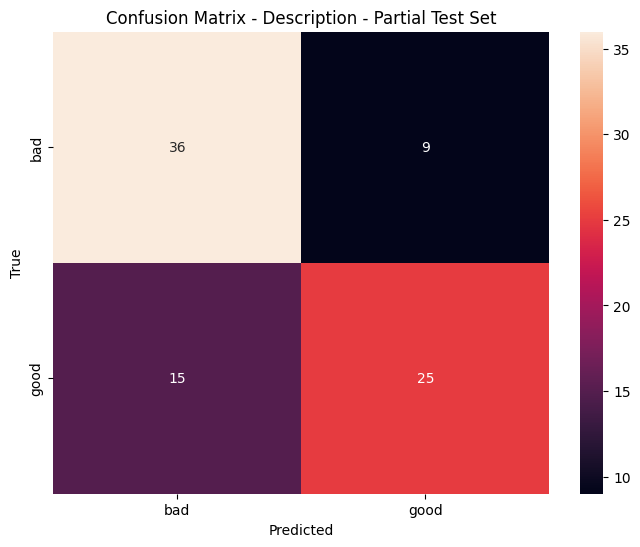

Pitch Type (Partial merged model): FS
Description (Partial merged model): bad
Description score: 0.33


In [39]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def traj_vec_filter(traj_vec, aspect_ratio_threshold=0.33):
    """
    過濾不合理的軌跡框（非棒球的偵測框）。
    參數:
        traj_vec: List of [x1, y1, x2, y2]
        aspect_ratio_threshold: 當高寬比或寬高比 > 1 + threshold 時視為非正方形
    回傳:
        過濾後的軌跡
    """
    filtered = []
    for box in traj_vec:
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1
        if w <= 0 or h <= 0:
            continue
        aspect_ratio = w / h
        if (1 - aspect_ratio_threshold) <= aspect_ratio <= (1 + aspect_ratio_threshold):
            filtered.append(box)
    return filtered

# 1. 設定 player list
player_name_list = [
    'Shohei_Ohtani_SL','Shohei_Ohtani_FS','Shohei_Ohtani_FF',
    #'Gerrit_Cole_CH','Gerrit_Cole_FF','Gerrit_Cole_SL',
    #'Yu_Darvish_FF','Yu_Darvish_FS','Yu_Darvish_SL',
]

# 2. 收集資料
X_data = []
y1_data = []
y2_data = []

max_len = 0

for player_name in tqdm(player_name_list):
    folder = f'/content/drive/MyDrive/Baseball Movies/{player_name}_videos_4S/baseball_trajectory_bbox_with_pitch_type_description'
    if not os.path.exists(folder):
        continue
    for fname in os.listdir(folder):
        if not fname.endswith('.pkl'):
            continue
        with open(os.path.join(folder, fname), 'rb') as f:
            data = pickle.load(f)
        traj = data['trajectory']
        traj_vec_raw = [list(t[1:]) if t[1] is not None else [0,0,0,0] for t in traj]
        traj_vec = traj_vec_filter(traj_vec_raw)
        max_len = max(max_len, len(traj_vec))
        X_data.append(traj_vec)
        y1_data.append(data['pitch_type'])
        y2_data.append(data['description'])

# 3. 轉成二分類 description
def convert_description_to_binary(desc):
    desc = desc.lower()
    if ('strike' in desc) or ('foul' in desc):
        return 'good'
    else:
        return 'bad'

y2_binary = [convert_description_to_binary(d) for d in y2_data]

# 4. Padding function
def pad_sequence(seq, max_len):
    pad_len = max_len - len(seq)
    return seq + [[0,0,0,0]] * pad_len

X_padded = [pad_sequence(x, max_len) for x in X_data]
X_array = np.array(X_padded).reshape(len(X_padded), -1)  # 展平

# 5. Label encoding
le_pitch_type = LabelEncoder()
y1_encoded = le_pitch_type.fit_transform(y1_data)

le_description = LabelEncoder()
y2_encoded = le_description.fit_transform(y2_binary)

# 6. 建立複合標籤並過濾少於2筆的類別
y_combined = list(zip(y1_encoded, y2_encoded))
counter = Counter(y_combined)
filtered_indices = [i for i, label in enumerate(y_combined) if counter[label] >= 2]

X_filtered = X_array[filtered_indices]
y_combined_filtered = [y_combined[i] for i in filtered_indices]

# 7. 切分資料集 (80% train + 20% test) 且 stratify
X_train, X_test, y_combined_train, y_combined_test = train_test_split(
    X_filtered, y_combined_filtered, test_size=0.2, random_state=42, stratify=y_combined_filtered
)

y1_train = np.array([y[0] for y in y_combined_train])
y2_train = np.array([y[1] for y in y_combined_train])
y1_test = np.array([y[0] for y in y_combined_test])
y2_test = np.array([y[1] for y in y_combined_test])
num_add = int(len(X_test) * 0.25)

X_test_part = X_test[:num_add]
y1_test_part = y1_test[:num_add]
y2_test_part = y2_test[:num_add]

X_test_remain = X_test
y1_test_remain = y1_test
y2_test_remain = y2_test

X_train_new = np.concatenate([X_train, X_test_part], axis=0)
y1_train_new = np.concatenate([y1_train, y1_test_part], axis=0)
y2_train_new = np.concatenate([y2_train, y2_test_part], axis=0)

# 9. 訓練新的模型
clf_pitch_type_new = RandomForestClassifier(n_estimators=100, random_state=42)
clf_description_new = RandomForestClassifier(n_estimators=100, random_state=42)

clf_pitch_type_new.fit(X_train_new, y1_train_new)
clf_description_new.fit(X_train_new, y2_train_new)

# 10. 評估函數
def show_results(y_true, y_pred, labels, title):
    from sklearn.utils.multiclass import unique_labels
    used_labels = unique_labels(y_true, y_pred)

    print(f'== {title} ==')
    print(classification_report(
        y_true, y_pred,
        labels=used_labels,
        target_names=[labels[i] for i in used_labels]
    ))

    cm = confusion_matrix(y_true, y_pred, labels=used_labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=[labels[i] for i in used_labels],
                yticklabels=[labels[i] for i in used_labels])
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 11. 用剩餘測試資料評估
y1_pred_remain = clf_pitch_type_new.predict(X_test_remain)
y2_pred_remain = clf_description_new.predict(X_test_remain)

show_results(y1_test_remain, y1_pred_remain, le_pitch_type.classes_, 'Pitch Type - Partial Test Set')
show_results(y2_test_remain, y2_pred_remain, le_description.classes_, 'Description - Partial Test Set')

# 12. 建立前處理類別 & pipeline
class TrajectoryPreprocessor:
    def __init__(self, max_len):
        self.max_len = max_len

    def transform(self, X_raw):
        out = []
        for traj in X_raw:
            traj_vec_raw = [list(t[1:]) if t[1] is not None else [0,0,0,0] for t in traj]
            traj_vec = traj_vec_filter(traj_vec_raw)
            traj_vec = pad_sequence(traj_vec, self.max_len)
            out.append(traj_vec)
        return np.array(out).reshape(len(out), -1)

trajectory_preprocessor = TrajectoryPreprocessor(max_len=max_len)

pipeline_pitch_type_new = Pipeline([
    ('preprocess', trajectory_preprocessor),
    ('rf', clf_pitch_type_new)
])

pipeline_description_new = Pipeline([
    ('preprocess', trajectory_preprocessor),
    ('rf', clf_description_new)
])

# 13. 推論示範（用一筆新資料）
with open('/content/drive/MyDrive/Baseball Movies/Gerrit_Cole_CH_videos_4S/baseball_trajectory_bbox_with_pitch_type_description/pitch_0029_baseball_trajectory_with_label.pkl', 'rb') as f:
    one_data = pickle.load(f)

X_new = [one_data['trajectory']]
pred1_new = pipeline_pitch_type_new.predict(X_new)
pred2_new = pipeline_description_new.predict(X_new)

print("Pitch Type (Partial merged model):", le_pitch_type.inverse_transform(pred1_new)[0])
print("Description (Partial merged model):", le_description.inverse_transform(pred2_new)[0])
print("Description score:", pipeline_description_new.predict_proba(X_new)[0][1])


# save_model

In [40]:
import joblib
import pickle
import os

def save_model(
    pitch_model, desc_model,
    le_pitch_type, le_description,
    max_len, save_dir='saved_model'
):
    """
    儲存模型、LabelEncoder 和 Preprocessor 設定。
    """
    os.makedirs(save_dir, exist_ok=True)

    joblib.dump(pitch_model, os.path.join(save_dir, 'clf_pitch_type.pkl'))
    joblib.dump(desc_model, os.path.join(save_dir, 'clf_description.pkl'))

    with open(os.path.join(save_dir, 'le_pitch_type.pkl'), 'wb') as f:
        pickle.dump(le_pitch_type, f)

    with open(os.path.join(save_dir, 'le_description.pkl'), 'wb') as f:
        pickle.dump(le_description, f)

    with open(os.path.join(save_dir, 'preprocessor_config.pkl'), 'wb') as f:
        pickle.dump({'max_len': max_len}, f)

    print(f'Models and configs saved to: {save_dir}')
# 儲存模型
save_model(
    pitch_model=clf_pitch_type_new,
    desc_model=clf_description_new,
    le_pitch_type=le_pitch_type,
    le_description=le_description,
    max_len=max_len,
    save_dir='saved_model'
)

Models and configs saved to: saved_model


# 另一台電腦使用方式

In [41]:
def load_model(load_dir='saved_model'):
    """
    載入模型、LabelEncoder 和 Preprocessor，回傳推論用的 pipeline。
    回傳:
        pipeline_pitch, pipeline_desc, le_pitch_type, le_description
    """
    clf_pitch = joblib.load(os.path.join(load_dir, 'clf_pitch_type.pkl'))
    clf_desc = joblib.load(os.path.join(load_dir, 'clf_description.pkl'))

    with open(os.path.join(load_dir, 'le_pitch_type.pkl'), 'rb') as f:
        le_pitch = pickle.load(f)

    with open(os.path.join(load_dir, 'le_description.pkl'), 'rb') as f:
        le_desc = pickle.load(f)

    with open(os.path.join(load_dir, 'preprocessor_config.pkl'), 'rb') as f:
        config = pickle.load(f)

    # 必須事先定義 TrajectoryPreprocessor 類別
    preprocessor = TrajectoryPreprocessor(max_len=config['max_len'])

    pipeline_pitch = Pipeline([
        ('preprocess', preprocessor),
        ('rf', clf_pitch)
    ])

    pipeline_desc = Pipeline([
        ('preprocess', preprocessor),
        ('rf', clf_desc)
    ])

    return pipeline_pitch, pipeline_desc, le_pitch, le_desc


# 另一台電腦或下次啟動時載入
pipeline_pitch, pipeline_desc, le_pitch, le_desc = load_model('saved_model')

# 推論
with open('/content/drive/MyDrive/Baseball Movies/Shohei_Ohtani_SL_videos_4S/baseball_trajectory_bbox_with_pitch_type_description/pitch_0001_baseball_trajectory_with_label.pkl', 'rb') as f:
    one_data = pickle.load(f)

X_new = [one_data['trajectory']]
print("Pitch Type:", le_pitch.inverse_transform(pipeline_pitch.predict(X_new))[0])
print("Description:", le_desc.inverse_transform(pipeline_desc.predict(X_new))[0])
print("Description score:", pipeline_desc.predict_proba(X_new)[0][1])

Pitch Type: ST
Description: good
Description score: 0.82
